<a href="https://colab.research.google.com/github/lockiultra/SCAMT/blob/main/dataset_prepare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q drug-named-entity-recognition
# !pip install -q cirpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.0 MB/s eta 0:00:00


In [33]:
import nltk
from nltk.tokenize import wordpunct_tokenize, word_tokenize
from drug_named_entity_recognition import find_drugs
from bs4 import BeautifulSoup
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import json
import os

import warnings
warnings.filterwarnings('ignore')

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
diseases = [disease[:-4] for disease in os.listdir('./drive/MyDrive/SCAMT')]

In [14]:
diseases

['cardiovascular_disease',
 'urinary_system_disease',
 'digestive_system_disease',
 'immune_system_disease',
 'mental_and_behavioural_disorder',
 'metabolic_disease',
 'nervous_system_disease',
 'skin_and_connective_tissue_disease']

In [15]:
def get_smiles(drug):
  api_url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{drug}/json'
  response = json.loads(requests.get(api_url).text)
  if response.get('PC_Compounds'):
    for i in response.get('PC_Compounds')[0]['props']:
      if i['urn'].get('label') == 'SMILES' and i['urn'].get('name') == 'Canonical':
        return i['value']['sval']

def get_drugs(drugs):
  res = [None] * len(drugs)
  for i, drug in enumerate(drugs):
    res[i] = drug[0]['name']
  return ';'.join(res)

def drug_split(data, disease):
  df = pd.DataFrame(columns=['Conditions', 'Drug', 'Smiles'])
  for i in range(data.shape[0]):
    for drug in data.iloc[i]['Interventions'].split(';'):
      df = df.append({'Conditions': data.iloc[i]['Conditions'], 'Drug': drug, 'Smiles': None, 'Disease': f'{disease}'}, ignore_index=True)
  return df

def get_prepared_data(data, disease):
  data['Interventions'] = data['Interventions'].map(lambda x: get_drugs(find_drugs(wordpunct_tokenize(x))))
  data = data[data['Interventions'] > '']
  data = drug_split(data, disease)
  data = data.drop_duplicates(subset=['Drug'])
  data['Smiles'] = data['Drug'].map(lambda x: get_smiles(x))
  data = data.dropna()
  return data

In [17]:
data = pd.DataFrame(columns=['Conditions', 'Drug', 'Smiles'])

for disease in tqdm(diseases):
  curr_df = pd.read_csv(f'./drive/MyDrive/SCAMT/{disease}.csv', usecols=['Conditions', 'Interventions'])
  curr_df = get_prepared_data(curr_df, disease)
  frames = [data, curr_df]
  data = pd.concat(frames)

100%|██████████| 8/8 [1:13:02<00:00, 547.76s/it]


In [19]:
data.to_csv('./drive/MyDrive/SCAMT/data.csv')

In [20]:
data

,Conditions,Drug,Smiles,Disease
0,Multiple Myeloma,Bortezomib,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,cardiovascular_disease
1,Multiple Myeloma,Dexamethasone,CC1CC2C3CCC4=CC(=O)C=CC4(C3(C(CC2(C1(C(=O)CO)O...,cardiovascular_disease
2,Myeloma,Minocycline,CN(C)C1C2CC3CC4=C(C=CC(=C4C(=C3C(=O)C2(C(=C(C1...,cardiovascular_disease
3,Myeloma,Ciclosporin,CCC1C(=O)N(CC(=O)N(C(C(=O)NC(C(=O)N(C(C(=O)NC(...,cardiovascular_disease
4,Myeloma,Chloroquine,CCN(CC)CCCC(C)NC1=C2C=CC(=CC2=NC=C1)Cl,cardiovascular_disease
...,...,...,...,...
219,Dermatomyositis,Methotrexate,CN(CC1=CN=C2C(=N1)C(=NC(=N2)N)N)C3=CC=C(C=C3)C...,skin_and_connective_tissue_disease
223,Systemic Sclerosis,Imatinib,CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C...,skin_and_connective_tissue_disease
225,T-Cell Peripheral Lymphoma|Gamma Delta Hepatos...,Etoposide,CC1OCC2C(O1)C(C(C(O2)OC3C4COC(=O)C4C(C5=CC6=C(...,skin_and_connective_tissue_disease
228,T-Cell Peripheral Lymphoma|Gamma Delta Hepatos...,Vincristine,CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...,skin_and_connective_tissue_disease


In [24]:
data['Drug'].unique().shape

(1726,)

In [30]:
data = data.drop_duplicates(subset=['Drug'])

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'cardiovascular_disease'),
  Text(1, 0, 'digestive_system_disease'),
  Text(2, 0, 'urinary_system_disease'),
  Text(3, 0, 'immune_system_disease'),
  Text(4, 0, 'nervous_system_disease'),
  Text(5, 0, 'metabolic_disease'),
  Text(6, 0, 'mental_and_behavioural_disorder'),
  Text(7, 0, 'skin_and_connective_tissue_disease')])

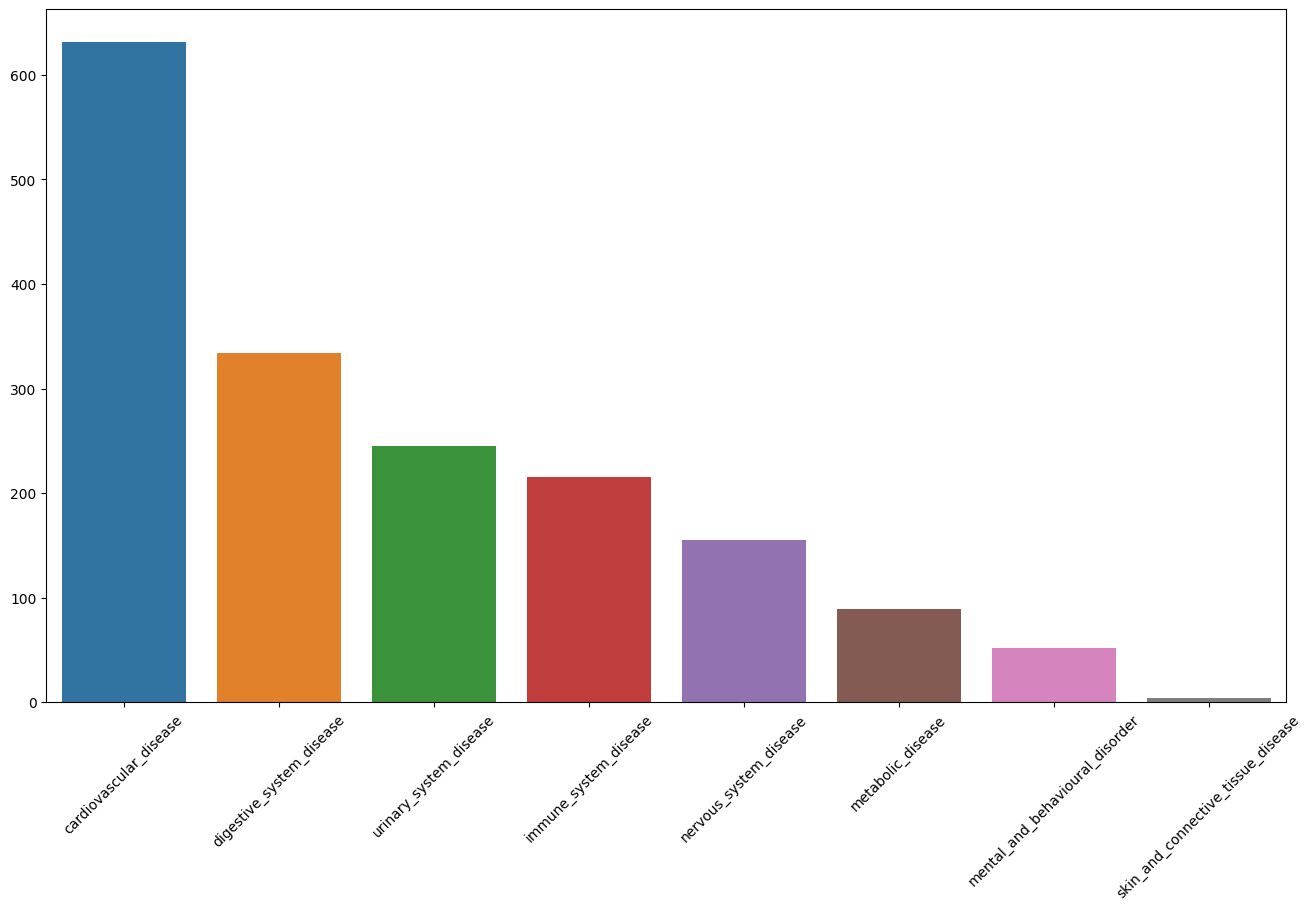

In [49]:
plt.figure(figsize=(16, 9))
sns.barplot(x=data['Disease'].value_counts().index, y=data['Disease'].value_counts().values)
plt.xticks(rotation=45)

In [50]:
data['Disease'].value_counts()

cardiovascular_disease                631
digestive_system_disease              334
urinary_system_disease                245
immune_system_disease                 216
nervous_system_disease                155
metabolic_disease                      89
mental_and_behavioural_disorder        52
skin_and_connective_tissue_disease      4
Name: Disease, dtype: int64

In [51]:
data.to_csv('./drive/MyDrive/SCAMT/data_without_dupl.csv')